In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

In [4]:
np.random.seed(123)
tf.random.set_seed(123)            

In [6]:
#!pip install -u scikit-learn


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [5]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [6]:
import pandas_datareader as web 


In [7]:
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2019,9,1)

In [8]:
df = web.DataReader('BLK','yahoo',start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,333.459991,329.010010,333.040009,333.100006,958900.0,281.060516
2016-01-05,336.100006,329.119995,334.190002,333.959991,803200.0,281.786194
2016-01-06,331.899994,327.000000,327.279999,330.160004,1138500.0,278.579895
2016-01-07,325.649994,312.609985,320.600006,315.730011,1285300.0,266.404266
2016-01-08,319.760010,307.029999,317.559998,307.779999,1500200.0,259.696198


In [9]:
df['LogClose'] = np.log(df['Close'])

In [10]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,LogClose
Date,,,,,,,
2016-01-04,333.459991,329.010010,333.040009,333.100006,958900.0,281.060516,5.808443
2016-01-05,336.100006,329.119995,334.190002,333.959991,803200.0,281.786194,5.811021
2016-01-06,331.899994,327.000000,327.279999,330.160004,1138500.0,278.579895,5.799577
2016-01-07,325.649994,312.609985,320.600006,315.730011,1285300.0,266.404266,5.754887
2016-01-08,319.760010,307.029999,317.559998,307.779999,1500200.0,259.696198,5.729385


In [11]:
df['DiffLogClose'] = df['LogClose'].diff()

In [12]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,LogClose,DiffLogClose
Date,,,,,,,,
2016-01-04,333.459991,329.010010,333.040009,333.100006,958900.0,281.060516,5.808443,NaN
2016-01-05,336.100006,329.119995,334.190002,333.959991,803200.0,281.786194,5.811021,0.002578
2016-01-06,331.899994,327.000000,327.279999,330.160004,1138500.0,278.579895,5.799577,-0.011444
2016-01-07,325.649994,312.609985,320.600006,315.730011,1285300.0,266.404266,5.754887,-0.044690
2016-01-08,319.760010,307.029999,317.559998,307.779999,1500200.0,259.696198,5.729385,-0.025502


In [13]:
Ntest = 12
train = df.iloc[: -Ntest]
test = df.iloc[-Ntest:]

In [14]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.transform(test[['DiffLogClose']])

In [15]:
# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [16]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [17]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,LogClose,DiffLogClose,ScaledLogReturn
Date,,,,,,,,,
2016-01-04,333.459991,329.010010,333.040009,333.100006,958900.0,281.060516,5.808443,NaN,NaN
2016-01-05,336.100006,329.119995,334.190002,333.959991,803200.0,281.786194,5.811021,0.002578,0.166608
2016-01-06,331.899994,327.000000,327.279999,330.160004,1138500.0,278.579895,5.799577,-0.011444,-0.829110
2016-01-07,325.649994,312.609985,320.600006,315.730011,1285300.0,266.404266,5.754887,-0.044690,-3.189916
2016-01-08,319.760010,307.029999,317.559998,307.779999,1500200.0,259.696198,5.729385,-0.025502,-1.827397


In [18]:
# Make a supervised dataset
series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) -T):
  x = series[t: t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
  
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (911, 10) Y.shape (911,)


In [19]:
Xtrain, Ytrain = X[: -Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [20]:
# Basic ANN

i = Input(shape = (T,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)

2022-10-11 19:01:50.680639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 19:01:50.683329: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model.compile(loss= "mse", optimizer = 'adam', metrics= 'mae')

In [22]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs = 200,
    validation_data = (Xtest, Ytest)
    )

Epoch 1/200
29/29 [==============================] - 1s 16ms/step - loss: 1.3102 - mae: 0.8341 - val_loss: 1.6549 - val_mae: 0.9719
Epoch 2/200
29/29 [==============================] - 0s 11ms/step - loss: 1.0945 - mae: 0.7536 - val_loss: 1.4226 - val_mae: 0.9064
Epoch 3/200
29/29 [==============================] - 0s 5ms/step - loss: 1.0301 - mae: 0.7323 - val_loss: 1.2792 - val_mae: 0.8608
Epoch 4/200
29/29 [==============================] - 0s 6ms/step - loss: 1.0068 - mae: 0.7246 - val_loss: 1.2127 - val_mae: 0.8456
Epoch 5/200
29/29 [==============================] - 0s 5ms/step - loss: 0.9924 - mae: 0.7190 - val_loss: 1.2110 - val_mae: 0.8574
Epoch 6/200
29/29 [==============================] - 0s 5ms/step - loss: 0.9826 - mae: 0.7158 - val_loss: 1.1575 - val_mae: 0.8477
Epoch 7/200
29/29 [==============================] - 0s 6ms/step - loss: 0.9767 - mae: 0.7124 - val_loss: 1.1317 - val_mae: 0.8458
Epoch 8/200
29/29 [==============================] - 0s 5ms/step - loss: 0.9692 -

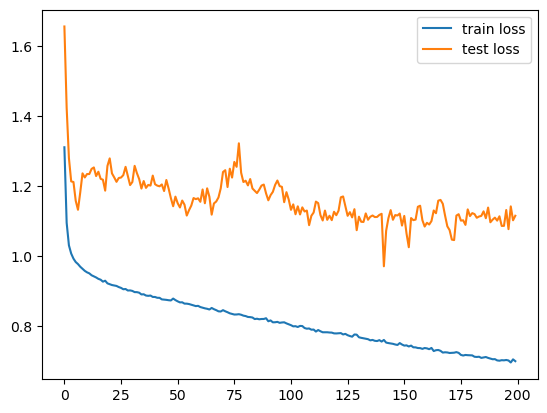

In [23]:
plt.plot( r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

In [24]:
train_idx[:T+1] = False # First T+1 values are not predictable

In [25]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

In [26]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN train prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN test prediction'] = Ptest

In [27]:
cols = ['DiffLogClose', 'Diff ANN train prediction', 'Diff ANN test prediction']

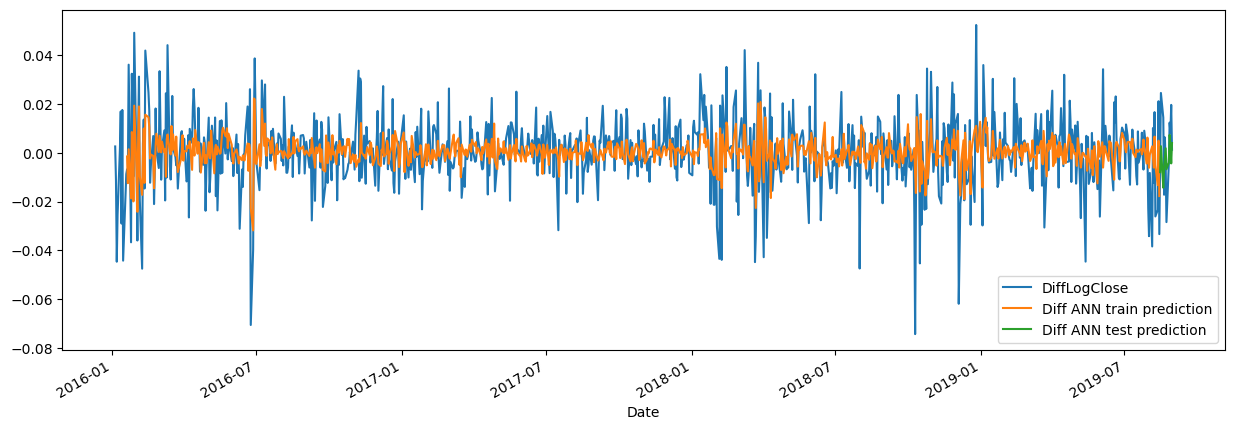

In [28]:
df[cols].plot(figsize = (15,5));

In [29]:
# Needed to compute un-differenciated predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [30]:
# Last know train value
last_train = train.iloc[-1]['LogClose']

In [31]:
# 1-Step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest


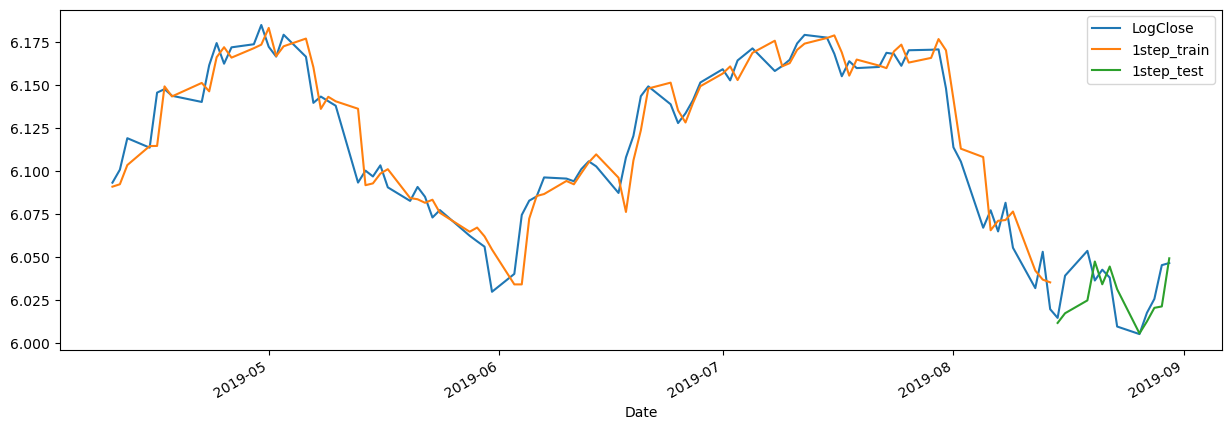

In [32]:
# 1-step forecast
df.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize= (15,5));

### Multistep forecast

In [33]:
multistep_predictions = []
# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1,-1))[0]
  #update the predictions list
  multistep_predictions.append(p)
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [34]:
# unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(
    multistep_predictions.reshape(-1,1)).flatten()

In [35]:
# save multistep forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

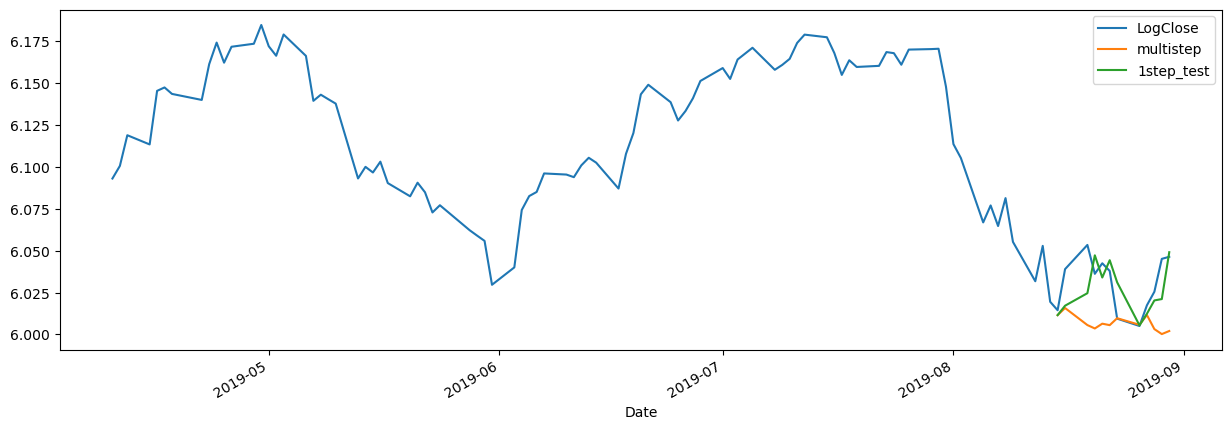

In [36]:
# plot 1-step and multistep forecast
df[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize= (15,5));

## Make multioutput supervised dataset

In [38]:
Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series)- Tx -Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t + Tx: t + Tx + Ty]
  Y.append(y)

X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (900, 10) Y.shape (900, 12)


In [39]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [40]:
# Basic ANN
i = Input(shape = (Tx,))
X = Dense(32, activation = 'relu')(i)
X = Dense(Ty)(X)
model = Model(i,X)


In [41]:
model.compile( loss='mse', optimizer='adam')

In [42]:
r = model.fit(Xtrain_m,
              Ytrain_m, 
              epochs=100, 
              validation_data=(Xtest_m, Ytest_m) 
              )

Epoch 1/100
29/29 [==============================] - 1s 14ms/step - loss: 1.1710 - val_loss: 2.5754
Epoch 2/100
29/29 [==============================] - 0s 11ms/step - loss: 1.0930 - val_loss: 2.4242
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 1.0522 - val_loss: 2.2644
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 1.0275 - val_loss: 2.1218
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 1.0106 - val_loss: 2.0536
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9981 - val_loss: 1.9665
Epoch 7/100
29/29 [==============================] - 0s 6ms/step - loss: 0.9886 - val_loss: 1.9324
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 0.9812 - val_loss: 1.8293
Epoch 9/100
29/29 [==============================] - 0s 7ms/step - loss: 0.9759 - val_loss: 1.8271
Epoch 10/100
29/29 [==============================] - 0s 6ms/step - loss: 0.9708 - val_loss: 1.8032
Epoch 1

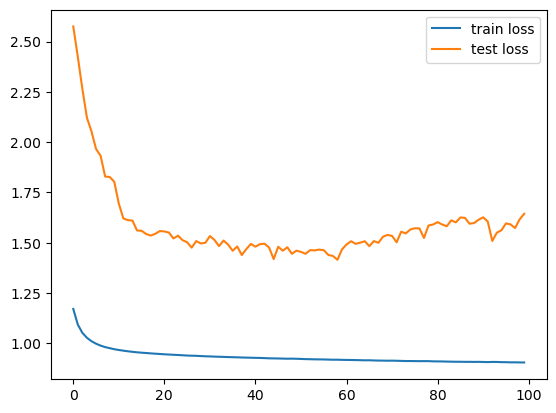

In [43]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

In [44]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)
Ptrain.shape, Ptest.shape

((899, 12), (1, 12))

In [45]:
Ptrain = Ptrain[:, 0]
Ptest = Ptest[0]

In [46]:
# unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1,1)).flatten()

In [47]:
# Save multioutput to dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

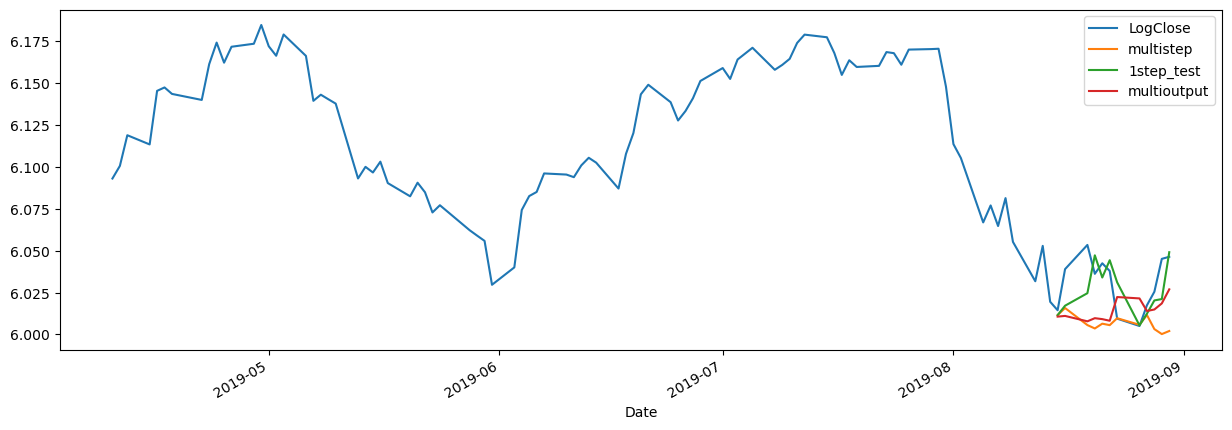

In [48]:
# Plot all forecast

cols = ['LogClose', 'multistep', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize= (15,5));

In [49]:
# MAPE

test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print('multistep', mape1)
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print('multi-output MAPE', mape2)

multistep 0.004042996121197268
multi-output MAPE 0.0035350937652704243


## 1- Step Binary Classification

In [50]:
Ytrain_b = (Ytrain > 0)*1
Ytest_b = (Ytest > 0)*1

In [51]:
# Basic ANN

i = Input(shape = (T,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)

In [52]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits= True), optimizer = 'adam', metrics = ['accuracy'],
              )

In [53]:
r = model.fit(
    Xtrain,
    Ytrain_b,
    epochs = 100,
    validation_data = (Xtest, Ytest_b)
)

Epoch 1/100
29/29 [==============================] - 1s 17ms/step - loss: 0.7826 - accuracy: 0.4939 - val_loss: 0.6823 - val_accuracy: 0.4167
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.7308 - accuracy: 0.4917 - val_loss: 0.6107 - val_accuracy: 0.5000
Epoch 3/100
29/29 [==============================] - 0s 9ms/step - loss: 0.7103 - accuracy: 0.4928 - val_loss: 0.5852 - val_accuracy: 0.5000
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.7009 - accuracy: 0.4928 - val_loss: 0.5852 - val_accuracy: 0.5833
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6950 - accuracy: 0.5050 - val_loss: 0.5972 - val_accuracy: 0.5833
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5083 - val_loss: 0.5909 - val_accuracy: 0.5833
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.5206 - val_loss: 0.6026 - val_accuracy: 0.5833
Epoch 8/100


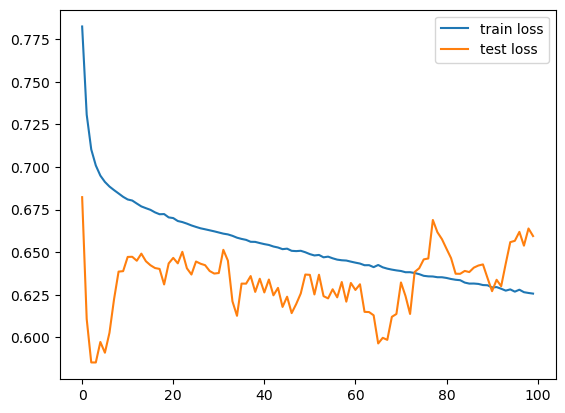

In [54]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

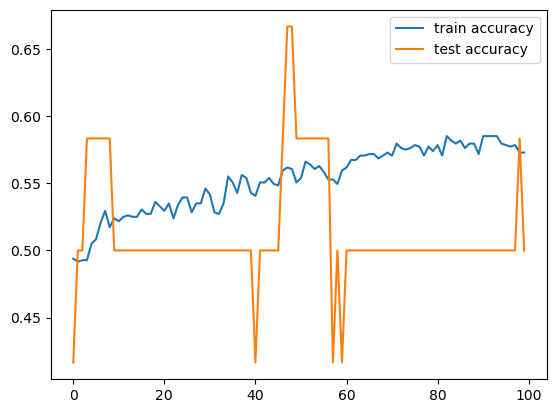

In [55]:
plt.plot(r.history['accuracy'], label = 'train accuracy')
plt.plot(r.history['val_accuracy'], label = 'test accuracy')
plt.legend();

This is preatty missleading!
Therefore you have to consider another metric such as R2

Exercise:

Do you think differencing is unnecessary? Try it!

Do you think logging is unnecessary? Try it!

Do you think including more past lags would be useful?

Have you consider walkforward validation to optimize hyperparameters?

What is a better metric?